# Deep Learning Project 1 - CNN 
Samyam Lamichhane  <br>
April 20, 2023

---------------

## How to run the program?
- Press [Command (CTRL) + RETURN] on individual cells respectively to run the program manually 
Or, 
- Press [CTRL + F9] to run all the cells from scratch (on Google Colab). Alternatively, from the menu, you can select <Run All Cell>. 

<br>

NOTE: <br>
To avoid any remnant of any variables, it is a good idea to stop the kernel before running the program.
<br> 

-> To do this, press [CTRL + M + .] (Google Colab) or select [Stop button] at the menubar. 
    
<br> <br>

# Introduction
Image classification is the process of taking an input (like a picture) and outputting a class (like “cat”) or a probability that the input is a particular class (“there’s a 90% probability that this input is a cat”). You can look at a picture and know that you’re looking at a terrible shot of your own face, but how can a computer learn to do that? With a convolutional neural network!

-----
# Goals
We would like you to establish a neural network involving advance DNN modules (i.e. convolution layers, RELU, pooling and fully connection layers and etc.)  to distinguish the specific category of an input image.

-------------
## Packages
Let's first import the necessary packages,

In [1]:
from __future__ import division

import warnings
from collections import namedtuple
import torch
import torch.nn as nn
from torch.jit.annotations import Optional, Tuple
from torch import Tensor
import os
import numpy as np
import os.path
from glob import glob
from PIL import Image
from tqdm import tqdm
import torchvision.datasets as dset
import torch.utils.data as data
from ipywidgets import IntProgress

-----
## GPU Device Configuration
Then, we set up and configure our computational devices: 
Whether we use GPU or perform the calculation on CPU.
we use the torch.devices() and torch.cude.is_available() functions to configure our computational devices

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda')

-----
## Configuration
### hyper parameters
We then set up and hyper parameters that need for the our model.
we need to define several hyper parameters for our model:
1. learning rate
2. batch size when training
3. batch size when testing
4. numbper of epoches
5. out put directory

In [3]:
# Learning Rate
eta = 0.01

# Batch Sizes
trainBatchSize, testBatchSize = 20, 20

# Number of epoches
n_epoch = 60

# Output Directory
OUTPUT_DIR = "./output_dir/"

Create a directory if not exists
using os.path.exists() to check whether it is exist
using os.makedires to create a directory.

In [4]:
import os 

if os.path.exists(OUTPUT_DIR):
    print("Directory already exists.")
else:
    os.makedirs(OUTPUT_DIR)
    print("Directory created.") 
    print("Name of the directory: ", OUTPUT_DIR)

print()

Directory already exists.



-----
##  Data Loading
Next, we are going to load our data. 
### We need to prepare our data:

### We first import necessary librarys for data loading

In [5]:
from torchvision import transforms

-----
###  Image processing
Then, we define a image preprocessing object that our dataloader can directly use this object to preprocess our data
We use the pytorch API to preform the data processing.
1. Use transforms.Compose()
2. Use .RandomHorizontalFlip()
3. You add any extra transforms you like.
4. Create this transform for both training set and testting set. Note that the testing spilit do not require any transform

In [6]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

-----
### We then download and prepare the data with the transforms defined above:
1. Use command torchvision.datasets.CIFAR10() with root, train, download and transform posional arguments.
2. Use the same command to create both train split and test split.
3. Use torch.utils.data.DataLoader() to create the data loader based on the data we have.
3. Use this command for both training split data loader and test split data loader

In [7]:
# train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
# train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=trainBatchSize, shuffle=True)
# test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
# test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=testBatchSize, shuffle=False)

train_set = dset.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=trainBatchSize, shuffle=True)
test_set = dset.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=testBatchSize, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


-----
##  Network
Next, we are going to design our GoogLeNet
### First, we define our GoogLeNet class
### You need to refer the paper below to understand the structure.
### https://arxiv.org/abs/1409.4842



------
### Inception Module with dimension reductions (There exist many implement methods)
1. Create a python class called Inception which inherits nn.module

2. Create a init function to init this python class
    1. Require in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x and pool_planes 7 arguments.
    
    2. Consists of 4 variables b1,b2,b3,b4
    
    3. b1 is a block consists of 2D convolution, a 2D batch normalization layer and a ReLU activation function
    
    4. b2 is a block consists of two 2D convolutions, two 2D batch normalization layers and tow ReLU activation functions
    
    5. b3 is a block consists of two 2D convolutions, two 2D batch normalization layers and two ReLU activation functions
    
    6. b4 is a block consists of a Maxpooling layer, a 2D convolution, a 2D batch normalization layer and a ReLU activation function
    
3. Create the forward function

    1. this forward function will forward the input function though every block and return the concatenation of all the output.

In [8]:

'''
Arguments:

    in_planes   = # input channels (module)
    
    kernel_1_x  = # output channels (b1)
    
    kernel_3_in = # output channels (b2) (1x1)
    kernel_3_x  = # output channels (b2) (3x3)
    
    kernel_5_in = # output channels (b3) (1x1)
    kernel_5_x  = # output channels (b3) (5x5)
    
    pool_planes = # output channels (b4).
    
    
Inception:
    3x3 Conv: Padding = 1
    5x5 Conv: Padding = 2
    MaxPool:  Padding = 1
    
'''

# Inheritance -> from nn.Module
class Inception(nn.Module):
    
    
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size = 1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True)
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            # 1x1 conv
            nn.Conv2d(in_planes, kernel_3_in, kernel_size = 1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            
            # 3x3 conv
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True)
        )


        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            # 1x1 Conv
            nn.Conv2d(in_planes, kernel_5_in, kernel_size = 1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            
            # 5x5 conv
            # nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size = 5, padding = 1), 
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size = 5, padding = 2), 
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True)
        )
         

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            # Max Pooling
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
            
            # 1x1 Conv
            nn.Conv2d(in_planes, pool_planes, kernel_size = 1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True)
        )
       
    
    # 3(A) - Forward Pass & Concatenation
    def forward(self, x):
        b1_out = self.b1(x)
        b2_out = self.b2(x)
        b3_out = self.b3(x)
        b4_out = self.b4(x)
        
        return torch.cat([b1_out, b2_out, b3_out, b4_out], 1)


-----
### GoogLeNet Module (There exist many implement methods)


1. Create a python class called GoogLeNet which inherits nn.module

2. Create a init function to init this python class

    1. Consists of a variables that serves as all layers before the inception, which contains a 2D convolution with padding=1, kernel_size=3 output channel=192, a 2D batch normalization layer and a ReLU activation fucntion.
    
    2. Two Inception blocks
    
    3. Maxpooling layer
    
    4. Five Inception blocks
    
    5. Maxpooling layer
    
    6. Two Inception blocks  
    
    7. Average Pooling layer
    
    8. A fully connected layer.
    
3. Create the forward function

    1. this forward function will forward the input function though every block and return the output

In [9]:

'''
Arguments: 

    pre_in_channel  = # Input Channels (pre-inception)
    pre_out_channel = # Output Channels (pre-inception)
    
    final_in_size = Input Size (final fully connected layer)
    final_n_class = Output size (final fully connected layer)
    

Google Net:
    
    Pre_inception:
        kernel_size = 3, padding = 1

    MaxPool:
        kernel_size = 3, stride = 2, padding = 1
    
    AvgPool:
        kernel_size = 8, stride = 1, no padding

'''

# GoogLeNet architecture class based on project manual

class GoogLeNet(nn.Module):
    
    def __init__(self, pre_in_channel, pre_out_channel, final_in_size, final_n_class):
        super(GoogLeNet, self).__init__()
        
        # 2(A) - PreInception Layer
        self.layer_0 = nn.Sequential(
            
            # 2D Conv with given parameters: input channel = 2, output channel = 192, kernel = 3, padding = 1
            # Batch Normalization (output)
            # ReLU
            nn.Conv2d(pre_in_channel, pre_out_channel, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(pre_out_channel), 
            nn.ReLU(True)
        )
        
        
        # 2(B) - Two Inception Blocks
        self.inception_first_1 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception_first_2 = Inception(256, 128, 128, 192, 32, 96, 64)
        
        # 2(C) - MaxPooling 2D
        self.maxPool_first = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        # 2(D) - Five Inception Blocks
        self.inception_second_1 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception_second_2 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception_second_3 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception_second_4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception_second_5 = Inception(528, 256, 160, 320, 32, 128, 128)
        
        # 2(E) - MaxPooling 2D
        self.maxPool_second = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        # 2(F) - Two Inception Blocks
        self.inception_third_1 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception_third_2 = Inception(832, 384, 192, 384, 48, 128, 128)
        
        
        # 2(G) - Average Pooling
        self.avgPool = nn.AvgPool2d(kernel_size = 8, stride = 1)
        
        # 2(H) - Fully Connected Layer
        self.layer_final = nn.Linear(final_in_size, final_n_class)
    
    
    
    
    # 3(A) - Forward Pass through all the blocks: each block separated by spacing
    def forward(self, x):
        
        # Pre-inception layer
        x = self.layer_0(x)
        
        # 2 Inception Blocks
        x = self.inception_first_1(x)
        x = self.inception_first_2(x)
        
        # First Max Pooling
        x = self.maxPool_first(x)
        
        # 5 Inception Blocks
        x = self.inception_second_1(x)
        x = self.inception_second_2(x)
        x = self.inception_second_3(x)
        x = self.inception_second_4(x)
        x = self.inception_second_5(x)
        
        # Second Max Pooling
        x = self.maxPool_second(x)
        
        # 2 Inception Blocks
        x = self.inception_third_1(x)
        x = self.inception_third_2(x)
        
        # Average Pooling
        x = self.avgPool(x)
        
        # Flatten
        # x = x.flatten()
        x = x.reshape(x.shape[0], -1)
        
        # Fully Connected Final Layer
        x = self.layer_final(x)
        
        return x
        
        

### Next, we create the network and send it to the target device

In [10]:
# Parameters for GoogLeNet object

'''
    pre_in_channel  = # Input Channels (pre-inception)
    pre_out_channel = # Output Channels (pre-inception)
    
    final_in_size = Input Size (final fully connected layer)
    final_n_class = Output size (final fully connected layer)
'''


pre_in_channel, pre_out_channel = 3, 192
final_in_size, final_n_class = 1024, 10

In [11]:
# Instantiating the object and sending it to the target device

googlenet_obj = GoogLeNet(pre_in_channel, pre_out_channel, final_in_size, final_n_class)
googlenet_obj.to(device)

GoogLeNet(
  (layer_0): Sequential(
    (0): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (inception_first_1): Inception(
    (b1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (b2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (b3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, 

### Finally, We create:
 1. an optimizer  (we use adam optimzer here)
 2. A Criterion (CrossEntropy) function
 3. A Scheduler which is used to decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.

In [12]:
# (1) - Optimizer
myOptimizer = torch.optim.Adam(googlenet_obj.parameters(), lr = eta)

# (2) - CrossEntropy Loss Function
loss_func = torch.nn.CrossEntropyLoss()

# (3) - Scheduler to decay learning rate
# milestone_list = torch.arange(10, 50, 10)            # 10, 20, 30, 40
milestone_list = [50, 100]
gamma_val = 0.5

lr_decay = torch.optim.lr_scheduler.MultiStepLR(myOptimizer, milestones = milestone_list, gamma = gamma_val)

-----
##  Training
Then, we are going to train our Network

1. Set our network to the training model.
2. Init the train loss, total data and number corrected predictions. 
3. For each data in the training split
    1. Put the data to the correct devices using .to()
    2. Reset the gradient of the optimzier.
    3. Feed the data forward to the google net
    4. Use the criterion function to compute the loss term
    5. Backprop the loss
    6. Update the network parameters using the optimzier
    7. Accumulate the training loss
    8. Find the prediciton. hint: using torch.max()
    9. Increment the data size
    10. Increment the corrected prediction
    11. Print log
    
-----
##  Testing
Then, we are going to test our module

1. Set our network to the test model.
2. Init the test loss, total data and number corrected predictions. 
3. For each data in the training split, we warp it using torch.no_grad()
    1. Put the data to the correct devices using .to()
    2. Feed the data forward to the google net
    3. Use the criterion function to compute the loss term
    4. Accumulate the training loss
    5. Find the prediciton. hint: using torch.max()
    6. Increment the data size
    7. Increment the corrected prediction
    8. Print log

-----
##  Epochs:
For each epoch:
1. we first step our scheduler
2. we train our module
3. we test our module
4. we update the testing accuracy
5. we save the module at the end and print the accuracy

In [13]:
# ------------------------------------- TRAINING ------------------------------------- 

'''
    Arguments: Train split data
    Returns: Train Loss and accuracy values

'''

# Function to train model - called inside epoch iteration
def trainModel(train_loader):

    # (1) Training Model
    googlenet_obj.train()

    # (2) Init variables
    loss_train, data_total_train, n_correct_train = 0, 0, 0

    # (3) Loop through training split
    for (input_tr, label_tr) in train_loader:
        
        # (A) Correct Device
        input_tr, label_tr = input_tr.to(device), label_tr.to(device)
        
        # (B) Zero Gradient
        myOptimizer.zero_grad()
        
        # (C) Forward Feed
        prediction_temp_tr = googlenet_obj(input_tr)
        # prediction_temp_tr = googlenet_obj.forward(input_tr)
        
        # (D) Criterion Function: (pred, original)
        loss_tr = loss_func(prediction_temp_tr, label_tr)
        
        # (E) Backprop
        loss_tr.backward()
        
        # (F) Update the parameters
        myOptimizer.step()
        
        # (G) Accumulate Training Loss: .item() to convert tensor to python variable
        loss_train += loss_tr.item()
        
        # (H) Prediction
        max_elem_tr, max_idx_tr = torch.max(prediction_temp_tr, dim = 1)
        
        # (I) Increment the data size
        data_total_train += label_tr.size(0)
        
        # (J) Increment the correct prediction
        n_correct_train += torch.sum(max_idx_tr == label_tr).item()
        
        # (K) Print log (later on)
    
    train_acc = (n_correct_train)/ (data_total_train)
    
    # ------------------
    print("\nTraining Loss: ", loss_train, " & Training Accuracy: ", train_acc)
    # ------------------
    
    return loss_train, train_acc

In [14]:
# ------------------------------------- TESTING ------------------------------------- 

'''
    Arguments: Test split data
    Returns: Test Loss and accuracy values

'''

# Function to test model - called inside epoch iteration
def testModel(test_loader):

    # (1) Training Model
    googlenet_obj.eval()

    # (2) Init variables
    loss_test, data_total_test, n_correct_test = 0, 0, 0

    # (3) Loop through testing split
    #     Warp it using no_grad()
    for (input_te, label_te) in test_loader:
        
        with torch.no_grad():
            # (A) Correct Device
            input_te, label_te = input_te.to(device), label_te.to(device)

            # (B) Forward Feed
            prediction_temp_te = googlenet_obj(input_te)

            # (C) Criterion Function: (pred, original)
            loss_te = loss_func(prediction_temp_te, label_te)

            # (D) Accumulate Training Loss: .item() to convert tensor to python variable
            loss_test += loss_te.item()

            # (E) Prediction
            max_elem_te, max_idx_te = torch.max(prediction_temp_te, dim = 1)

            # (F) Increment the data size
            data_total_test += label_te.size(0)

            # (G) Increment the correct prediction
            n_correct_test += torch.sum(max_idx_te == label_te).item()

            # (H) Print log (later on)
    
    test_acc = (n_correct_test)/ (data_total_test)
    
    # ------------------
    print("\nTesting Loss: ", loss_test, " & Testing Accuracy: ", test_acc, "\n")
    # ------------------
    
    return loss_test, test_acc

In [15]:
# ------------------------------------- EPOCHS ------------------------------------- 


# Empty lists to store train and test loss and accuracy for all iterations
train_loss_list, test_loss_list = [], []
train_acc_list, test_acc_list = [], []


# Loop through n_epoch number of epoches
for epoch in range(n_epoch):
    
    print("\n\n------------" + " EPOCH " + str(epoch + 1) + " ------------\n")
    
    # (2) Train
    # Append training loss and accuracy (everything) to two lists
    loss_tr_, acc_tr_ = trainModel(train_loader)
    train_loss_list.append(loss_tr_)
    train_acc_list.append(acc_tr_)
    
    # (3) Test
    # Append testing loss and accuracy (everything) to two lists
    loss_te_, acc_te_ = testModel(test_loader)
    test_loss_list.append(loss_te_)
    test_acc_list.append(acc_te_)
    
    # (1) Step the scheduler
    lr_decay.step()
    
    # (4) - Done above in testing loop
    
    # (5) Save models in each epoch
    SAVE_FILE = OUTPUT_DIR + "file_ep_" + str(epoch + 1) + ".pt"
    torch.save(googlenet_obj.state_dict(), SAVE_FILE)
    

# Save a single file at the end
SAVE_FILE_FINAL = OUTPUT_DIR + "file_final.pt"
torch.save(googlenet_obj.state_dict(), SAVE_FILE_FINAL)



------------ EPOCH 1 ------------


Training Loss:  3955.560953617096  & Training Accuracy:  0.41666

Testing Loss:  646.7560365796089  & Testing Accuracy:  0.5394 



------------ EPOCH 2 ------------


Training Loss:  2485.2535955905914  & Training Accuracy:  0.64958

Testing Loss:  437.3870961666107  & Testing Accuracy:  0.696 



------------ EPOCH 3 ------------


Training Loss:  1937.3406461775303  & Training Accuracy:  0.73138

Testing Loss:  436.452565908432  & Testing Accuracy:  0.7052 



------------ EPOCH 4 ------------


Training Loss:  1636.5246446430683  & Training Accuracy:  0.77374

Testing Loss:  306.0979905799031  & Testing Accuracy:  0.7939 



------------ EPOCH 5 ------------


Training Loss:  1426.3301372155547  & Training Accuracy:  0.80362

Testing Loss:  288.31481570005417  & Testing Accuracy:  0.8037 



------------ EPOCH 6 ------------


Training Loss:  1262.5765830650926  & Training Accuracy:  0.82728

Testing Loss:  278.4379976540804  & Testing Accuracy


Testing Loss:  320.45784349399037  & Testing Accuracy:  0.8727 



------------ EPOCH 50 ------------


Training Loss:  127.16655384258365  & Training Accuracy:  0.98312

Testing Loss:  286.469730843477  & Testing Accuracy:  0.8859 



------------ EPOCH 51 ------------


Training Loss:  50.6420777234282  & Training Accuracy:  0.99372

Testing Loss:  241.53407823369344  & Testing Accuracy:  0.9064 



------------ EPOCH 52 ------------


Training Loss:  42.59435499025426  & Training Accuracy:  0.994

Testing Loss:  258.73323645161236  & Testing Accuracy:  0.908 



------------ EPOCH 53 ------------


Training Loss:  41.54454330255919  & Training Accuracy:  0.99416

Testing Loss:  261.72133781305456  & Testing Accuracy:  0.9023 



------------ EPOCH 54 ------------


Training Loss:  41.59957462081462  & Training Accuracy:  0.99452

Testing Loss:  272.24605077228625  & Testing Accuracy:  0.9026 



------------ EPOCH 55 ------------


Training Loss:  39.41968868532382  & Training Accu

<br>

## Plots

In [16]:
import matplotlib.pyplot as plt

In [17]:
# X-Axis values
x_axis = np.arange(0, n_epoch)

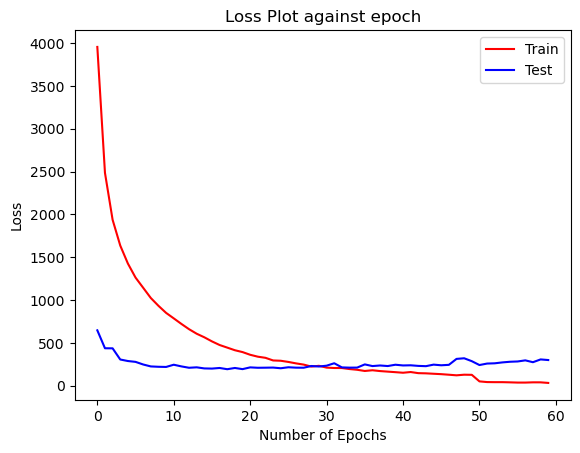

In [18]:
# Plotting loss against epoch number (everything)

plt.plot(x_axis, train_loss_list, color = "r", label = 'Train')
plt.plot(x_axis, test_loss_list, color = "b", label = 'Test')

plt.title("Loss Plot against epoch")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

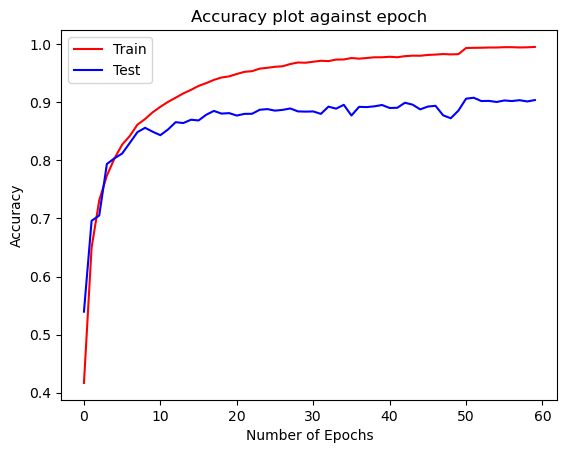

In [19]:
## Plotting Accuracy against epoch number (everything)

plt.plot(x_axis, train_acc_list, color = "r", label = 'Train')
plt.plot(x_axis, test_acc_list, color = "b", label = 'Test')

plt.title("Accuracy plot against epoch")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()